In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle
from interpretability.helpers import AttentionScoresLog
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/home/wdwatson2/projects/CAT-Transformer/model')
from testingModel import CATTransformer, MyFTTransformer, Combined_Dataset, train, test, EarlyStopping

device_in_use = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device_in_use)

cuda


In [3]:
df_train = pd.read_csv('/home/wdwatson2/projects/CAT-Transformer/datasets/helena/train.csv')
df_test = pd.read_csv('/home/wdwatson2/projects/CAT-Transformer/datasets/helena/test.csv')
df_val = pd.read_csv('/home/wdwatson2/projects/CAT-Transformer/datasets/helena/validation.csv')

cont_columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27']
target = ['class']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cont_columns + target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put one of them in the list"

target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
print("target classes",target_classes)
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

#Wrapping in Dataset
train_dataset = Combined_Dataset(df_train, cat_columns=[], num_columns=cont_columns, task1_column='class')
val_dataset = Combined_Dataset(df_val, cat_columns=[], num_columns=cont_columns, task1_column='class')
test_dataset = Combined_Dataset(df_test, cat_columns=[], num_columns=cont_columns, task1_column='class')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


target classes [100]


In [4]:
attention_log = AttentionScoresLog()

models = ["CAT", "FT"]
num_layers = [1,2,5]
datasets = ["Helena"]

for model in models:
    for layer in num_layers:
        attention_log.add_model_layers(model, layer)

attention_log.add_new_dataset('Helena')

In [5]:
model = CATTransformer(n_cont=len(cont_columns),
                       cat_feat=[],
                       targets_classes=target_classes,
                       get_attn=True,
                       num_layers=5).to(device_in_use)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001)

early_stopping = EarlyStopping(patience=5, verbose=True)

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 

train_attns = []
test_attns = []

epochs = 200

for t in range(epochs):
    train_loss, train_acc, train_attn = train(regression_on=False, 
                                  get_attn=True,
                                   dataloader=train_dataloader, 
                                   model=model, 
                                   loss_function=loss_function, 
                                   optimizer=optimizer, 
                                   device_in_use=device_in_use)
    test_loss, test_acc, test_attn = test(regression_on=False,
                               get_attn=True,
                               dataloader=test_dataloader,
                               model=model,
                               loss_function=loss_function,
                               device_in_use=device_in_use)
    train_losses.append(train_loss)
    train_accuracies_1.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies_1.append(test_acc)
    train_attns.append(train_attn)
    test_attns.append(test_attn)

    epoch_str = f"Epoch [{t+1:2}/{epochs}]"
    train_metrics = f"Train: Loss {(train_loss)}, Accuracy {(train_acc)}"
    test_metrics = f"Test: Loss {(test_loss)}, Accuracy {(test_acc)}"
    print(f"{epoch_str:15} | {train_metrics:65} | {test_metrics:65}")

    early_stopping(test_acc, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break


attention_log.add_attention_scores('CAT', 5, 'Helena', train_attns, test_attns)


Epoch [ 1/200]  | Train: Loss 4.1720277890146775, Accuracy 0.08451475776234196      | Test: Loss 3.778957941593268, Accuracy 0.12239263803680982       
Validation score improved. Saving model...
Epoch [ 2/200]  | Train: Loss 3.6109285048266364, Accuracy 0.18338190503319673      | Test: Loss 3.2908753064962535, Accuracy 0.252760736196319        
Validation score improved. Saving model...
Epoch [ 3/200]  | Train: Loss 3.2722764747768807, Accuracy 0.24800052588908122      | Test: Loss 3.1240287866347876, Accuracy 0.28016359918200406      
Validation score improved. Saving model...
Epoch [ 4/200]  | Train: Loss 3.1335298482266216, Accuracy 0.27289260906720425      | Test: Loss 3.023346858146863, Accuracy 0.30081799591002045       
Validation score improved. Saving model...
Epoch [ 5/200]  | Train: Loss 3.049218971636042, Accuracy 0.2854043867914192        | Test: Loss 2.9642440478006997, Accuracy 0.3062372188139059       
Validation score improved. Saving model...
Epoch [ 6/200]  | Train: 

In [7]:
train_scores, test_scores = attention_log.get_attention_scores('CAT', 5, 'Helena')
print(np.array(test_scores).shape)
avg_test = np.array(test_scores).squeeze(0)
avg_test = avg_test.mean(1)

(1, 66, 39, 5, 27)


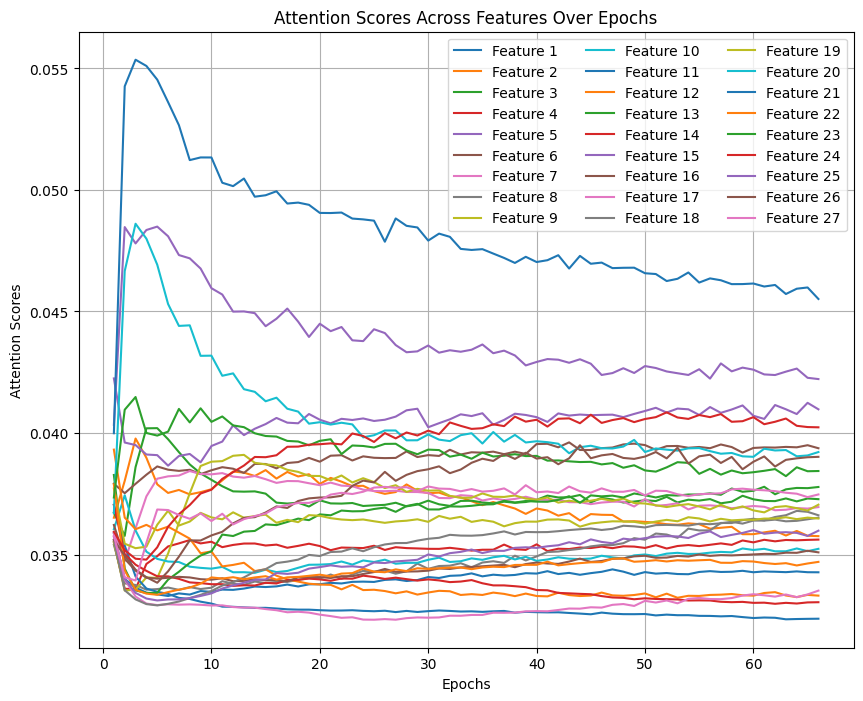

In [8]:
avg_test = avg_test.mean(1)
epochs = range(1, avg_test.shape[0]+1)  
num_features = avg_test.shape[1]

plt.figure(figsize=(10, 8))

# Plotting all features for the current layer
for feature_idx in range(num_features):
    plt.plot(epochs, avg_test[:, feature_idx], label=f'Feature {feature_idx + 1}')

plt.title(f'Attention Scores Across Features Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Attention Scores')
plt.legend(ncol=3) 
plt.grid(True)
plt.show()

In [9]:
df_val['class'].value_counts()

class
76    574
35    480
51    457
33    385
32    343
     ... 
2      15
27     15
37     14
26     13
52      9
Name: count, Length: 100, dtype: int64

In [10]:
sample_class76 = df_val.loc[df_val['class'] == 76]

sample_class76.shape
sample_class76 = sample_class76.sample(n=5)
input_class76 = sample_class76.drop('class', axis=1)
target_class76 = sample_class76['class']

In [11]:
#Now lets take model in evaluation mode and run certain samples through
#it

class_76_dataset = Combined_Dataset(sample_class76, cat_columns=[], num_columns=cont_columns, task1_column='class')

# Create a mini-dataloader
batch_size = 5  # Adjust batch size as needed
sample_dataloader = DataLoader(class_76_dataset, batch_size=batch_size)

# Define your evaluation function
def evaluate(model, dataloader, loss_function, device_in_use):
    model.eval()  # Set model to evaluation mode
    loss_vals = []
    accuracies = []
    attentions = []

    with torch.no_grad():
        for (cat_x, cont_x, labels) in dataloader:
            cat_x,cont_x,labels=cat_x.to(device_in_use),cont_x.to(device_in_use),labels.to(device_in_use)

            predictions, attention = model(cat_x, cont_x)

            loss = loss_function(predictions, labels.long())
            loss_vals.append(loss.item())

            _, predicted = torch.max(predictions, 1)
            accuracy = (predicted == labels).sum().item() / labels.size(0)
            accuracies.append(accuracy)

            attentions.append(attention.cpu().numpy())  # Assuming attn is a tensor of attention scores

    avg_loss = np.mean(loss_vals)
    avg_accuracy = np.mean(accuracies)
    all_attentions = np.concatenate(attentions, axis=0) if attentions else None

    return avg_loss, avg_accuracy, all_attentions

# Evaluate the model on the mini-dataloader
loss_function = torch.nn.CrossEntropyLoss()  # Define your loss function

sample_loss, sample_accuracy, sample_attentions = evaluate(model, sample_dataloader, loss_function, device_in_use)

print(f"Sample: Loss {sample_loss}, Accuracy {sample_accuracy}")

Sample: Loss 2.4679887294769287, Accuracy 0.6


In [12]:
sample_attentions_76 = sample_attentions.mean(0)
sample_attentions_76

array([0.03466678, 0.03513404, 0.03786559, 0.03434005, 0.04133718,
       0.03738388, 0.03647209, 0.03525802, 0.03623598, 0.03349295,
       0.03225653, 0.03361596, 0.03746707, 0.034221  , 0.04454351,
       0.03329536, 0.03345006, 0.03613587, 0.03751756, 0.03769563,
       0.05394318, 0.0356967 , 0.03845967, 0.03917329, 0.03478969,
       0.03959604, 0.03595638], dtype=float32)

In [13]:
sample_class26 = df_val.loc[df_val['class'] == 26]

sample_class26.shape
sample_class26 = sample_class26.sample(n=5)
input_class26 = sample_class26.drop('class', axis=1)
target_class26 = sample_class26['class']

class_26_dataset = Combined_Dataset(sample_class26, cat_columns=[], num_columns=cont_columns, task1_column='class')

# Create a mini-dataloader
batch_size = 5  # Adjust batch size as needed
sample_dataloader = DataLoader(class_26_dataset, batch_size=batch_size)

# Evaluate the model on the mini-dataloader
loss_function = torch.nn.CrossEntropyLoss()  # Define your loss function

sample_loss, sample_accuracy, sample_attentions = evaluate(model, sample_dataloader, loss_function, device_in_use)

print(f"Sample: Loss {sample_loss}, Accuracy {sample_accuracy}")

Sample: Loss 4.542147159576416, Accuracy 0.2


In [14]:
sample_attentions_26 = sample_attentions.mean(0)
sample_attentions_26

array([0.03464029, 0.03331156, 0.03595095, 0.03388268, 0.04152764,
       0.03806076, 0.0377672 , 0.03557708, 0.03663414, 0.03612276,
       0.03254031, 0.0330268 , 0.03924193, 0.03247105, 0.03882633,
       0.03766539, 0.03329498, 0.03667985, 0.03479533, 0.03887164,
       0.04505768, 0.0359477 , 0.04640037, 0.04030536, 0.03644719,
       0.03848486, 0.03646822], dtype=float32)

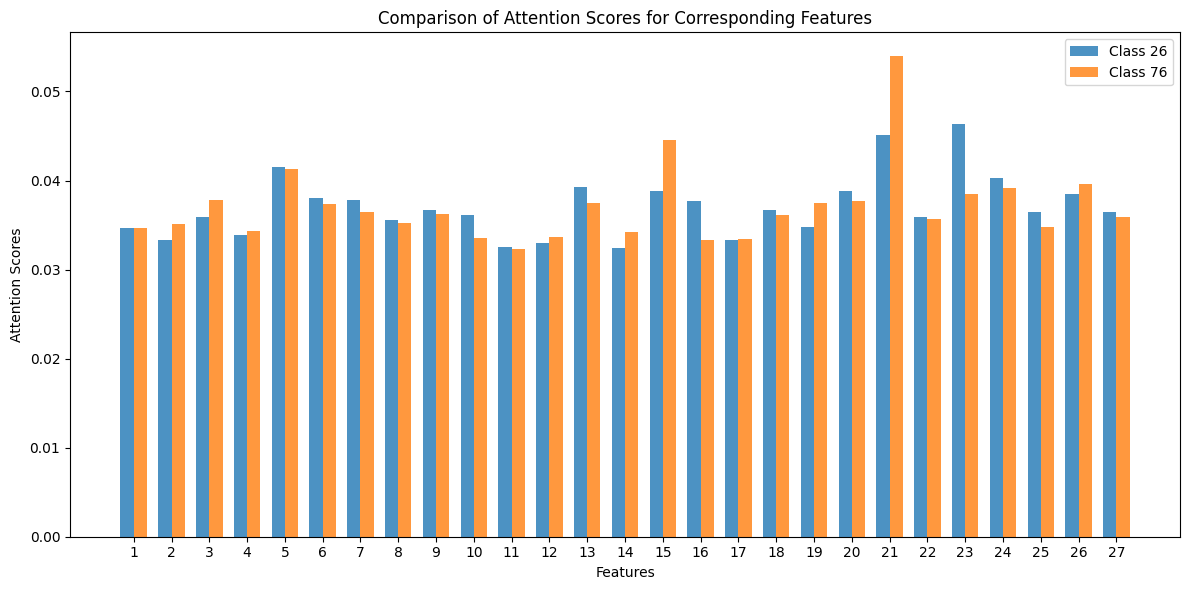

In [15]:
dist1 = sample_attentions_26
dist2 = sample_attentions_76

# Creating feature indices for x-axis ticks (assuming 27 features)
features = np.arange(1, 28)

# Plotting bar plots for comparison
plt.figure(figsize=(12, 6))

# Offset for bar width
bar_width = 0.35
index = np.arange(len(features))

# Plotting bars for each class
plt.bar(index, dist1, bar_width, label='Class 26', alpha=0.8)
plt.bar(index + bar_width, dist2, bar_width, label='Class 76', alpha=0.8)

plt.xlabel('Features')
plt.ylabel('Attention Scores')
plt.title('Comparison of Attention Scores for Corresponding Features')
plt.xticks(index + bar_width / 2, features)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
ft_model = MyFTTransformer(n_cont=len(cont_columns),
                       cat_feat=[],
                       targets_classes=target_classes,
                       get_attn=True,
                       num_layers=5).to(device_in_use)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=ft_model.parameters(), lr = 0.0001)

early_stopping = EarlyStopping(patience=5, verbose=True)

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 

train_attns = []
test_attns = []

epochs = 200

for t in range(epochs):
    train_loss, train_acc, train_attn = train(regression_on=False, 
                                  get_attn=True,
                                   dataloader=train_dataloader, 
                                   model=ft_model, 
                                   loss_function=loss_function, 
                                   optimizer=optimizer, 
                                   device_in_use=device_in_use)
    test_loss, test_acc, test_attn = test(regression_on=False,
                               get_attn=True,
                               dataloader=test_dataloader,
                               model=ft_model,
                               loss_function=loss_function,
                               device_in_use=device_in_use)
    train_losses.append(train_loss)
    train_accuracies_1.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies_1.append(test_acc)
    train_attns.append(train_attn)
    test_attns.append(test_attn)

    epoch_str = f"Epoch [{t+1:2}/{epochs}]"
    train_metrics = f"Train: Loss {(train_loss)}, Accuracy {(train_acc)}"
    test_metrics = f"Test: Loss {(test_loss)}, Accuracy {(test_acc)}"
    print(f"{epoch_str:15} | {train_metrics:65} | {test_metrics:65}")

    early_stopping(test_acc, ft_model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break


attention_log.add_attention_scores('FT', 5, 'Helena', train_attns, test_attns)


Epoch [ 1/200]  | Train: Loss 4.208391044392932, Accuracy 0.08657448999715144       | Test: Loss 3.767695610339825, Accuracy 0.14989775051124746       
Validation score improved. Saving model...
Epoch [ 2/200]  | Train: Loss 3.5902762000121218, Accuracy 0.18697548042158774      | Test: Loss 3.3041814473959117, Accuracy 0.25674846625766873      
Validation score improved. Saving model...
Epoch [ 3/200]  | Train: Loss 3.2844049038167773, Accuracy 0.24878935951092315      | Test: Loss 3.1389529643914638, Accuracy 0.26942740286298567      
Validation score improved. Saving model...
Epoch [ 4/200]  | Train: Loss 3.1514953594633988, Accuracy 0.27199421522010647      | Test: Loss 3.0402441941774807, Accuracy 0.29151329243353785      
Validation score improved. Saving model...
Epoch [ 5/200]  | Train: Loss 3.047432748965045, Accuracy 0.29042224510813597       | Test: Loss 2.944227756598057, Accuracy 0.3061349693251534        
Validation score improved. Saving model...
Epoch [ 6/200]  | Train: 

In [17]:
train_scores, test_scores = attention_log.get_attention_scores('FT', 5, 'Helena')
print(np.array(test_scores).shape)
avg_test = np.array(test_scores).squeeze(0)
avg_test = avg_test.mean(1)
avg_test = avg_test.mean(1)
avg_test.shape

(1, 75, 39, 5, 27)


(75, 27)

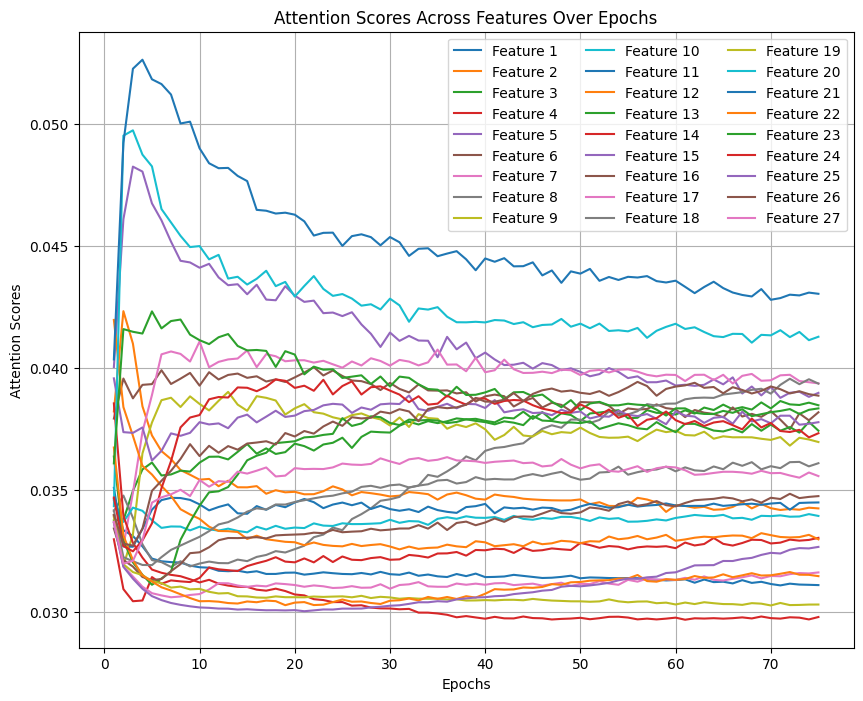

In [18]:
epochs = range(1, avg_test.shape[0]+1)  
num_features = avg_test.shape[1]

plt.figure(figsize=(10, 8))

# Plotting all features for the current layer
for feature_idx in range(num_features):
    plt.plot(epochs, avg_test[:, feature_idx], label=f'Feature {feature_idx + 1}')

plt.title(f'Attention Scores Across Features Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Attention Scores')
plt.legend(ncol=3) 
plt.grid(True)
plt.show()

In [21]:
# Evaluate the model on the mini-dataloader
loss_function = torch.nn.CrossEntropyLoss()  # Define your loss function

class_76_dataset = Combined_Dataset(sample_class76, cat_columns=[], num_columns=cont_columns, task1_column='class')

batch_size = 5  # Adjust batch size as needed
sample_dataloader = DataLoader(class_76_dataset, batch_size=batch_size)

sample_loss, sample_accuracy, sample_attentions_ft_76 = evaluate(ft_model, sample_dataloader, loss_function, device_in_use)

print(f"Sample: Loss {sample_loss}, Accuracy {sample_accuracy}")

Sample: Loss 2.515967845916748, Accuracy 0.6


In [22]:
sample_attentions_76_ft = sample_attentions_ft_76.mean(0)
sample_attentions_76_ft

array([0.0310835 , 0.0327855 , 0.03873812, 0.03399077, 0.04091477,
       0.03480761, 0.03868224, 0.03585707, 0.03684332, 0.03264748,
       0.03366082, 0.03323881, 0.03818139, 0.03051651, 0.0390249 ,
       0.03260987, 0.03125048, 0.03621762, 0.03141911, 0.04069671,
       0.04887843, 0.03269052, 0.03872082, 0.03703625, 0.03206807,
       0.03891548, 0.03639298], dtype=float32)

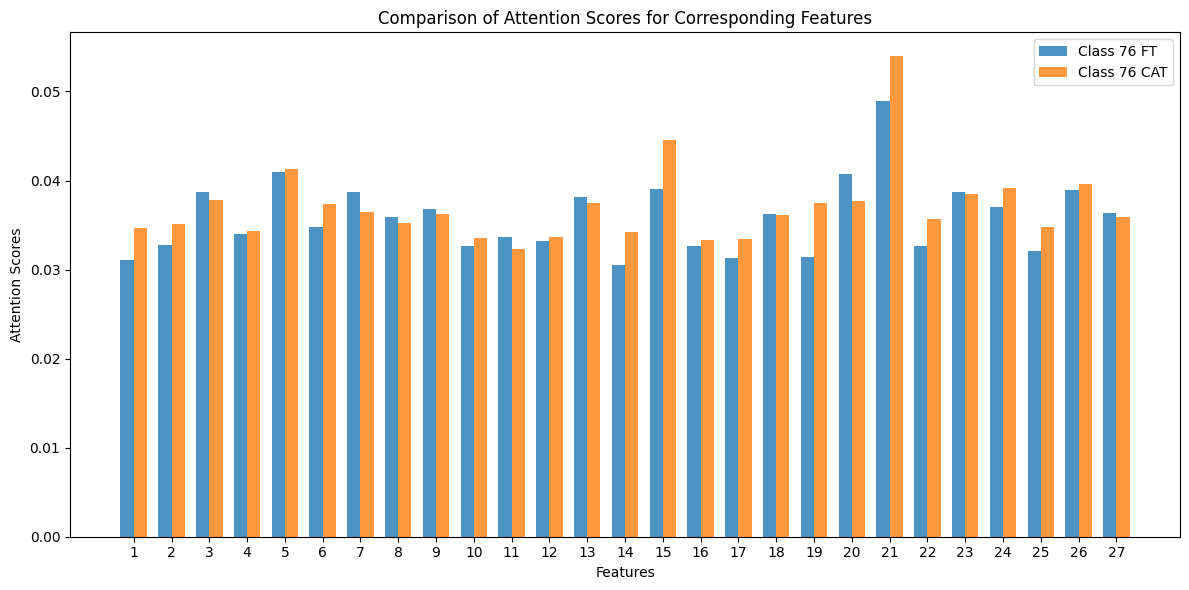

In [23]:
dist1 = sample_attentions_76_ft
dist2 = sample_attentions_76

# Creating feature indices for x-axis ticks (assuming 27 features)
features = np.arange(1, 28)

# Plotting bar plots for comparison
plt.figure(figsize=(12, 6))

# Offset for bar width
bar_width = 0.35
index = np.arange(len(features))

# Plotting bars for each class
plt.bar(index, dist1, bar_width, label='Class 76 FT', alpha=0.8)
plt.bar(index + bar_width, dist2, bar_width, label='Class 76 CAT', alpha=0.8)

plt.xlabel('Features')
plt.ylabel('Attention Scores')
plt.title('Comparison of Attention Scores for Corresponding Features')
plt.xticks(index + bar_width / 2, features)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Evaluate the model on the mini-dataloader
loss_function = torch.nn.CrossEntropyLoss()  # Define your loss function

class_26_dataset = Combined_Dataset(sample_class26, cat_columns=[], num_columns=cont_columns, task1_column='class')

batch_size = 5  # Adjust batch size as needed
sample_dataloader = DataLoader(class_26_dataset, batch_size=batch_size)

sample_loss, sample_accuracy, sample_attentions_ft_26 = evaluate(ft_model, sample_dataloader, loss_function, device_in_use)

print(f"Sample: Loss {sample_loss}, Accuracy {sample_accuracy}")

Sample: Loss 4.66142463684082, Accuracy 0.2


In [25]:
sample_attentions_26_ft = sample_attentions_ft_26.mean(0)
sample_attentions_26_ft

array([0.03019857, 0.03133032, 0.03886275, 0.03153955, 0.03797499,
       0.03708183, 0.03981195, 0.03787117, 0.03435238, 0.03342924,
       0.03435099, 0.03212962, 0.03778968, 0.03060104, 0.03903943,
       0.03707358, 0.03107867, 0.03509497, 0.02928066, 0.04328587,
       0.04285946, 0.03390401, 0.04170387, 0.03781075, 0.03226285,
       0.04144077, 0.03537451], dtype=float32)

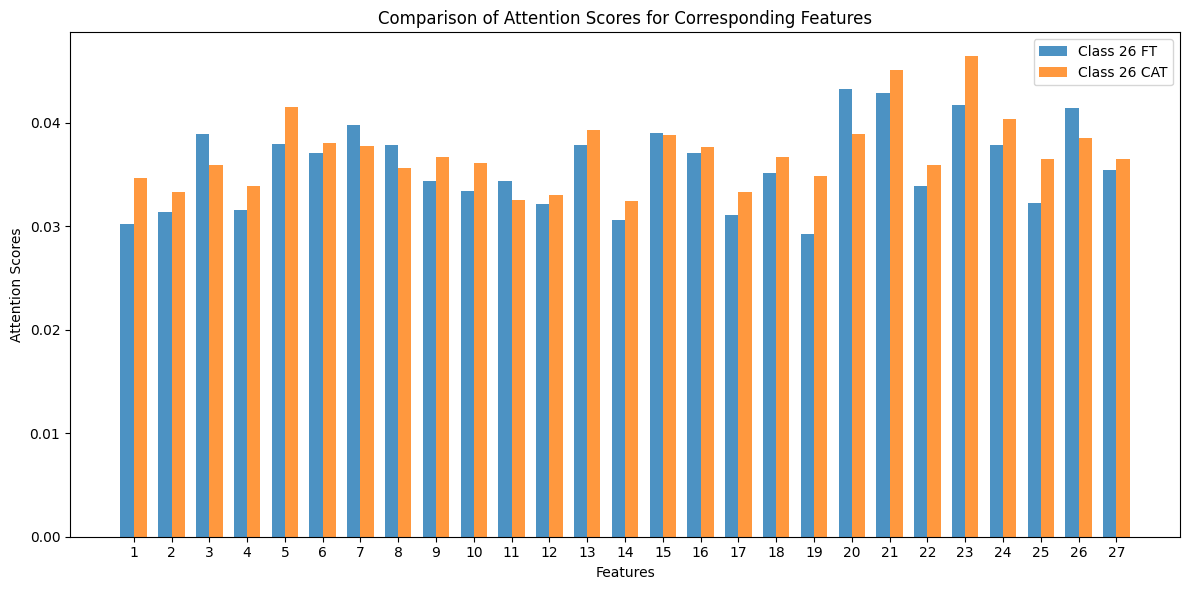

In [26]:
dist1 = sample_attentions_26_ft
dist2 = sample_attentions_26

# Creating feature indices for x-axis ticks (assuming 27 features)
features = np.arange(1, 28)

# Plotting bar plots for comparison
plt.figure(figsize=(12, 6))

# Offset for bar width
bar_width = 0.35
index = np.arange(len(features))

# Plotting bars for each class
plt.bar(index, dist1, bar_width, label='Class 26 FT', alpha=0.8)
plt.bar(index + bar_width, dist2, bar_width, label='Class 26 CAT', alpha=0.8)

plt.xlabel('Features')
plt.ylabel('Attention Scores')
plt.title('Comparison of Attention Scores for Corresponding Features')
plt.xticks(index + bar_width / 2, features)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# So there appears to be a slight difference between the two which we should expect. However, they are very very similar and would likely give similar feature rankings. 
# If we use only 1 layer, then we should expect basically no difference. Lets see what happens when we do such a thing

model = CATTransformer(n_cont=len(cont_columns),
                       cat_feat=[],
                       targets_classes=target_classes,
                       get_attn=True,
                       num_layers=1).to(device_in_use)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001)

early_stopping = EarlyStopping(patience=5, verbose=True)

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 

train_attns = []
test_attns = []

epochs = 200

for t in range(epochs):
    train_loss, train_acc, train_attn = train(regression_on=False, 
                                  get_attn=True,
                                   dataloader=train_dataloader, 
                                   model=model, 
                                   loss_function=loss_function, 
                                   optimizer=optimizer, 
                                   device_in_use=device_in_use)
    test_loss, test_acc, test_attn = test(regression_on=False,
                               get_attn=True,
                               dataloader=test_dataloader,
                               model=model,
                               loss_function=loss_function,
                               device_in_use=device_in_use)
    train_losses.append(train_loss)
    train_accuracies_1.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies_1.append(test_acc)
    train_attns.append(train_attn)
    test_attns.append(test_attn)

    epoch_str = f"Epoch [{t+1:2}/{epochs}]"
    train_metrics = f"Train: Loss {(train_loss)}, Accuracy {(train_acc)}"
    test_metrics = f"Test: Loss {(test_loss)}, Accuracy {(test_acc)}"
    print(f"{epoch_str:15} | {train_metrics:65} | {test_metrics:65}")

    early_stopping(test_acc, model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break


attention_log.add_attention_scores('CAT', 1, 'Helena', train_attns, test_attns)


Epoch [ 1/200]  | Train: Loss 4.18542987274724, Accuracy 0.08644301772684444        | Test: Loss 3.7498328502361593, Accuracy 0.15102249488752556      
Validation score improved. Saving model...
Epoch [ 2/200]  | Train: Loss 3.5962682156589443, Accuracy 0.19061287990008108      | Test: Loss 3.321420198831803, Accuracy 0.24171779141104294       
Validation score improved. Saving model...
Epoch [ 3/200]  | Train: Loss 3.284681456049061, Accuracy 0.25091482788088615       | Test: Loss 3.1218024094899497, Accuracy 0.28445807770961146      
Validation score improved. Saving model...
Epoch [ 4/200]  | Train: Loss 3.127841640451101, Accuracy 0.27815149987948373       | Test: Loss 3.0148393313090005, Accuracy 0.29703476482617586      
Validation score improved. Saving model...
Epoch [ 5/200]  | Train: Loss 3.0356653229484345, Accuracy 0.29184652803646166      | Test: Loss 2.9411595356770053, Accuracy 0.3141104294478528       
Validation score improved. Saving model...
Epoch [ 6/200]  | Train: 

Sample: Loss 2.5446441173553467, Accuracy 0.6
Sample: Loss 3.6051406860351562, Accuracy 0.4


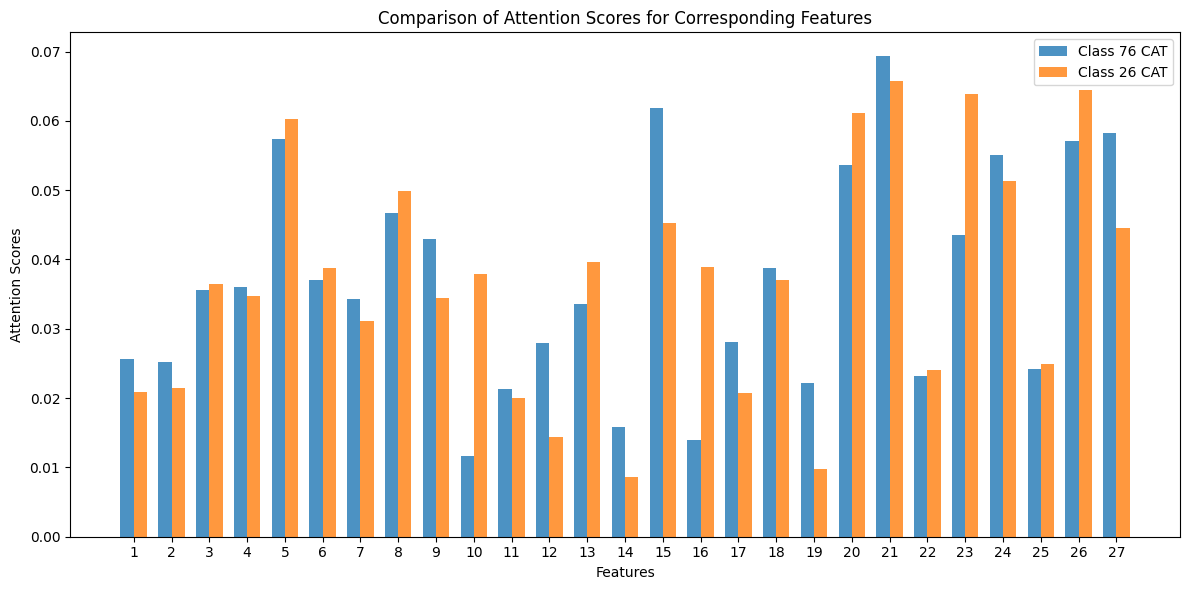

In [29]:
class_76_dataset = Combined_Dataset(sample_class76, cat_columns=[], num_columns=cont_columns, task1_column='class')

# Create a mini-dataloader
batch_size = 5  # Adjust batch size as needed
sample_dataloader = DataLoader(class_76_dataset, batch_size=batch_size)

# Evaluate the model on the mini-dataloader
loss_function = torch.nn.CrossEntropyLoss()  # Define your loss function

sample_loss, sample_accuracy, sample_attentions = evaluate(model, sample_dataloader, loss_function, device_in_use)

print(f"Sample: Loss {sample_loss}, Accuracy {sample_accuracy}")

sample_attentions_76 = sample_attentions.mean(0)

class_26_dataset = Combined_Dataset(sample_class26, cat_columns=[], num_columns=cont_columns, task1_column='class')

# Create a mini-dataloader
batch_size = 5  # Adjust batch size as needed
sample_dataloader = DataLoader(class_26_dataset, batch_size=batch_size)

# Evaluate the model on the mini-dataloader
loss_function = torch.nn.CrossEntropyLoss()  # Define your loss function

sample_loss, sample_accuracy, sample_attentions = evaluate(model, sample_dataloader, loss_function, device_in_use)

print(f"Sample: Loss {sample_loss}, Accuracy {sample_accuracy}")

sample_attentions_26 = sample_attentions.mean(0)

dist1 = sample_attentions_76
dist2 = sample_attentions_26

# Creating feature indices for x-axis ticks (assuming 27 features)
features = np.arange(1, 28)

# Plotting bar plots for comparison
plt.figure(figsize=(12, 6))

# Offset for bar width
bar_width = 0.35
index = np.arange(len(features))

# Plotting bars for each class
plt.bar(index, dist1, bar_width, label='Class 76 CAT', alpha=0.8)
plt.bar(index + bar_width, dist2, bar_width, label='Class 26 CAT', alpha=0.8)

plt.xlabel('Features')
plt.ylabel('Attention Scores')
plt.title('Comparison of Attention Scores for Corresponding Features')
plt.xticks(index + bar_width / 2, features)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
ft_model = MyFTTransformer(n_cont=len(cont_columns),
                       cat_feat=[],
                       targets_classes=target_classes,
                       get_attn=True,
                       num_layers=1).to(device_in_use)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=ft_model.parameters(), lr = 0.0001)

early_stopping = EarlyStopping(patience=5, verbose=True)

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 

train_attns = []
test_attns = []

epochs = 200

for t in range(epochs):
    train_loss, train_acc, train_attn = train(regression_on=False, 
                                  get_attn=True,
                                   dataloader=train_dataloader, 
                                   model=ft_model, 
                                   loss_function=loss_function, 
                                   optimizer=optimizer, 
                                   device_in_use=device_in_use)
    test_loss, test_acc, test_attn = test(regression_on=False,
                               get_attn=True,
                               dataloader=test_dataloader,
                               model=ft_model,
                               loss_function=loss_function,
                               device_in_use=device_in_use)
    train_losses.append(train_loss)
    train_accuracies_1.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies_1.append(test_acc)
    train_attns.append(train_attn)
    test_attns.append(test_attn)

    epoch_str = f"Epoch [{t+1:2}/{epochs}]"
    train_metrics = f"Train: Loss {(train_loss)}, Accuracy {(train_acc)}"
    test_metrics = f"Test: Loss {(test_loss)}, Accuracy {(test_acc)}"
    print(f"{epoch_str:15} | {train_metrics:65} | {test_metrics:65}")

    early_stopping(test_acc, ft_model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break


attention_log.add_attention_scores('FT', 1, 'Helena', train_attns, test_attns)

Epoch [ 1/200]  | Train: Loss 4.186946055076642, Accuracy 0.0797817560312904        | Test: Loss 3.7731036650828824, Accuracy 0.12065439672801637      
Validation score improved. Saving model...
Epoch [ 2/200]  | Train: Loss 3.61270814234984, Accuracy 0.18042377895128953        | Test: Loss 3.343708735245925, Accuracy 0.24171779141104294       
Validation score improved. Saving model...
Epoch [ 3/200]  | Train: Loss 3.3009804294096026, Accuracy 0.24977540153822556      | Test: Loss 3.1406095700386243, Accuracy 0.27791411042944786      
Validation score improved. Saving model...
Epoch [ 4/200]  | Train: Loss 3.1535616387202086, Accuracy 0.27287069702215305      | Test: Loss 3.0425472993117113, Accuracy 0.29478527607361965      
Validation score improved. Saving model...
Epoch [ 5/200]  | Train: Loss 3.0521110329548073, Accuracy 0.28950193921598705      | Test: Loss 2.9704242119422326, Accuracy 0.3075664621676892       
Validation score improved. Saving model...
Epoch [ 6/200]  | Train: 

In [31]:
class_76_dataset = Combined_Dataset(sample_class76, cat_columns=[], num_columns=cont_columns, task1_column='class')

# Create a mini-dataloader
batch_size = 5  # Adjust batch size as needed
sample_dataloader = DataLoader(class_76_dataset, batch_size=batch_size)

# Evaluate the model on the mini-dataloader
loss_function = torch.nn.CrossEntropyLoss()  # Define your loss function

sample_loss, sample_accuracy, sample_attentions = evaluate(ft_model, sample_dataloader, loss_function, device_in_use)

print(f"Sample: Loss {sample_loss}, Accuracy {sample_accuracy}")

sample_attentions_76_ft = sample_attentions.mean(0)

class_26_dataset = Combined_Dataset(sample_class26, cat_columns=[], num_columns=cont_columns, task1_column='class')

# Create a mini-dataloader
batch_size = 5  # Adjust batch size as needed
sample_dataloader = DataLoader(class_26_dataset, batch_size=batch_size)

# Evaluate the model on the mini-dataloader
loss_function = torch.nn.CrossEntropyLoss()  # Define your loss function

sample_loss, sample_accuracy, sample_attentions = evaluate(ft_model, sample_dataloader, loss_function, device_in_use)

print(f"Sample: Loss {sample_loss}, Accuracy {sample_accuracy}")

sample_attentions_26_ft = sample_attentions.mean(0)

Sample: Loss 2.6406641006469727, Accuracy 0.6
Sample: Loss 3.7913451194763184, Accuracy 0.6


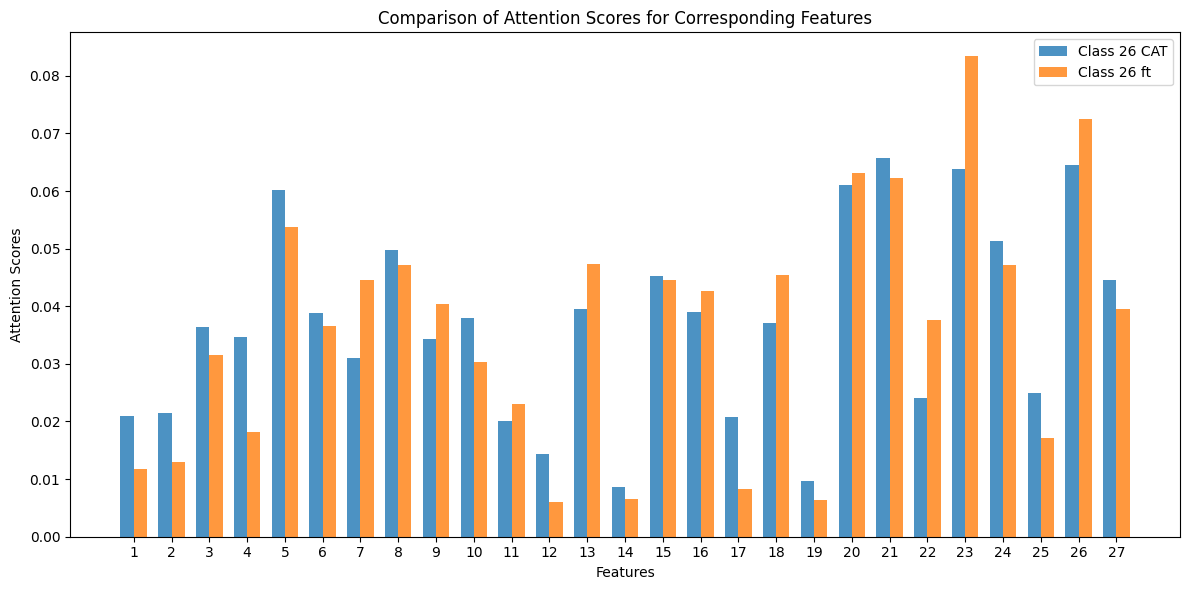

In [33]:
dist1 = sample_attentions_26
dist2 = sample_attentions_26_ft

# Creating feature indices for x-axis ticks (assuming 27 features)
features = np.arange(1, 28)

# Plotting bar plots for comparison
plt.figure(figsize=(12, 6))

# Offset for bar width
bar_width = 0.35
index = np.arange(len(features))

# Plotting bars for each class
plt.bar(index, dist1, bar_width, label='Class 26 CAT', alpha=0.8)
plt.bar(index + bar_width, dist2, bar_width, label='Class 26 ft', alpha=0.8)

plt.xlabel('Features')
plt.ylabel('Attention Scores')
plt.title('Comparison of Attention Scores for Corresponding Features')
plt.xticks(index + bar_width / 2, features)
plt.legend()
plt.tight_layout()
plt.show()